In [1]:
import pandas as pd
import numpy as np
import requests
import json
from dotenv import load_dotenv, find_dotenv
import os
import matplotlib.pyplot as plt
import matplotlib

In [2]:
#достаём переменные окружения
def load_env():
    
    load_dotenv(find_dotenv())
    url=os.getenv('API_URL')
    begin=os.getenv('DATE_BEGIN')
    end=os.getenv('DATE_END')
    link=[url, begin, end] 
    
    return(link)

In [3]:
# извлекаем данные в формат DataFrame
def load_data_set(link, name):
    
    resp=requests.get(f'{link[0]}/{name}?begin={link[1]}&end={link[2]}')
    r=resp.json()
    df=pd.DataFrame(r)
    df['datetime']=pd.to_datetime(df['datetime']).dt.date
    
    return(df)

In [4]:
# строим bar-plot для общих данных визитов и регистраций
def plot_total_bar(x, y, title, x_name, y_name):
    
    x_list=x.tolist()
    y_list=y.tolist()
        
    plt.figure(figsize=(18, 6)) 
    
    for i in range (len(x_list)):
        plt.text(x_list[i], y_list[i], y_list[i])
    
    plt.bar(x_list, y_list, width = 0.4)
    plt.title(title)
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.grid(axis='y')
    plt.xticks(x_list[::2], rotation=45)
    plt.xlim(x_list[0], x_list[-1])
    plt.tight_layout()
    
    
    plt.savefig(f'./{title}.png')

In [5]:
# строим bar-plot для визитов и регистраций в разрезе платформы или типа регистрации
def plot_by_type_bar(df, x, y, z, title, x_name, y_name):
    
    new=pd.pivot_table(df, index=x, columns=z, values=y)
    ax=new.plot(kind='bar', stacked=True, figsize=(18, 6),
                xlabel=x_name, ylabel=y_name, grid=True, title=title)
    
    plt.savefig(f'./{title}.png')

In [6]:
# строим pie-chart для регистраций в разрезе платформ и типа регистрации
def plot_pie(data1, data2, value, lable_1, lable_2):
    
    df1=data1.groupby([lable_1]).agg({value:'sum'}).reset_index()
    df2=data2.groupby([lable_2]).agg({value:'sum'}).reset_index()
    
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    plt.pie(x=df1[value], labels=df1[lable_1],
            autopct='%1.1f%%', textprops={'fontsize':12})             
    plt.title('Registration by Platform') 

    plt.subplot(1, 2, 2)
    plt.pie(x=df2[value], labels=df2[lable_2],
            autopct='%1.1f%%', textprops={'fontsize':12})              
    plt.title('Registration by Registration Type') 

       
    plt.savefig('./registrations_pie.png')

In [7]:
# график общей конверсии
def plot_line(x, y, title, x_name, y_name):
    
    plt.figure(figsize=(14,6))
    plt.plot(x, y)
    
    x_list=x.tolist()
    y_list=y.tolist()
    
    for i in range (len(x_list)):
        plt.text(x_list[i], y_list[i], y_list[i])
    
    plt.title(title)
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.grid(axis='y')
    plt.xticks(x_list[::2], rotation=45)
    plt.xlim(x_list[0], x_list[-1])
    plt.tight_layout()
    
    plt.savefig(f'./{title}.png')

In [8]:
# строим линейные графики для конверсий
def plot_conversion(df, x, y, types, x_name, y_name):
    
    df_plot=df[df['platform']==types].reset_index(drop=True)
    
    x_list=df_plot[x].tolist()
    y_list=df_plot[y].tolist()
    
    plt.figure(figsize=(14,6))
    plt.plot(x_list, y_list)
    
    for i in range (len(x_list)):
        plt.text(x_list[i], y_list[i], y_list[i])
    
    plt.title(f'conversion {types}')
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.grid(axis='y')
    plt.xticks(x_list[::2], rotation=45)
    plt.xlim(x_list[0], x_list[-1])
    plt.tight_layout()
    
    plt.savefig(f'./conversion {types}.png')

In [9]:
# визиты и регистрации с учётом рекламных кампаний
def plot_by_ads(df, x, y, z, title):
    
    fig, ax = plt.subplots(figsize=(16,6))
    
    ax.plot(df[x], df[y], label=y)
    
    x_list=df[x].tolist()
    z_list=list(df[z].unique())
    z_list.remove('none')
    colors=['blue', 'orange', 'green', 'red', 'purple']
    height=df[y].max()*1.05

    df['mean']=df[y].mean().round(0)
    
    for i in range (len(z_list)):
        df_rec=df[df[z]==z_list[i]]
        min_x=df_rec[x].min()
        max_x=df_rec[x].max()
        width=max_x-min_x
        rect = matplotlib.patches.Rectangle((min_x, 0),
                                            width,
                                            height,
                                            facecolor=colors[i],
                                            alpha = 0.1,
                                            label=z_list[i])
        ax.add_patch(rect)
    
    ax.plot(df[x], df['mean'], label='mean')
    
    ax.set_title(title)
    ax.legend()
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    
    ax.grid(which="major", linestyle="--",
            color="gray", linewidth=0.5)
    ax.grid(which="minor", linestyle="--",
            color="gray", linewidth=0.5)
    
    ax.set_xlim(df[x].min(), df[x].max())
    ax.set_ylim(0, height)
    
    ax.set_xticks(x_list[::2])
    ax.set_yticks(np.arange (0, height, round((height/15), -1)))
    
    ax.tick_params(axis='y', labelsize=10)
    ax.tick_params(axis='x', labelsize=10, labelrotation=45)
    
    plt.savefig(f'./{title}.png')

In [10]:
def run_all():
    
    # шаг 2 выгружаем данные
    link=load_env()
    df_visits=load_data_set(link, 'visits')
    df_registrations=load_data_set(link, 'registrations')
        
    # шаг 3 объединяем данные визитов и регистраций
    last_visit_dates=df_visits.groupby(['visit_id']).agg({'datetime':'max'}).reset_index()
    visits=pd.merge(last_visit_dates, df_visits, on=['datetime', 'visit_id']).groupby(['datetime', 'platform']).agg({'visit_id':'count'}).reset_index()
    v_st3=visits[visits.platform!='bot']
    r_st3=df_registrations.groupby(['datetime', 'platform']).agg({'user_id':'count'}).reset_index()
    
    # шаг 3 считаем конверсию
    conversion=pd.merge(v_st3, r_st3, on=['datetime', 'platform'])
    conversion['conversion']=conversion['user_id']/conversion['visit_id']*100
    conversion['conversion']=conversion['conversion'].round(1)                                                                              
    conversion.rename(columns={'datetime':'date_group', 'visit_id':'visits', 'user_id':'registrations'}, inplace=True)
    conversion=conversion.sort_values(by='date_group')
    conversion.to_json('./conversion.json')
    
    # шаг 4 добавляем данные рекламы к общей базе данных
    ads=pd.read_csv('./ads.csv')
    ads['date']=pd.to_datetime(ads['date']).dt.date
    
    total_conversion=conversion.drop(['platform', 'conversion'], axis=1).groupby(['date_group']).agg('sum').reset_index()
    total_conversion['conversion']=total_conversion['registrations']/total_conversion['visits']*100
    total_conversion['conversion']=total_conversion['conversion'].round(1)
    out=pd.merge(total_conversion, ads[['date','cost', 'utm_campaign']], left_on='date_group', right_on='date', how='left').drop(['date'], axis=1)
    out.rename(columns={'utm_campaign':'campaign'}, inplace=True)
    out['cost']=out['cost'].fillna('0')
    out['campaign']=out['campaign'].fillna('none')
    out=out.sort_values(by=['date_group'])
    out.to_json('./ads.json')
    
    # дополнительные данные для графиков
    data_reg=df_registrations.groupby(['datetime', 'registration_type']).agg({'user_id':'count'})
    
    # шаг 5 строим графики
        # графики общих визитов и регистраций по дням
    plot_total_bar(out['date_group'], out['visits'], 'Visits Count', 'date', 'visits_count')
    plot_total_bar(out['date_group'], out['visits'], 'Registrations Count', 'date', 'registrations_count')
    
        # графики визитов и регистраций в зависимости от платформы или типа регистрации
    plot_by_type_bar(conversion, 'date_group', 'visits', 'platform', 'Visits by Platform', 'date', 'visits_count_by_platform')
    plot_by_type_bar(conversion, 'date_group', 'registrations', 'platform', 'Registrations by Platform', 'date', 'registrations_count_by_platform')
    
    plot_by_type_bar(data_reg, 'datetime', 'user_id', 'registration_type', 'Registrations by Registration Type', 'date', 'registrations_count_by_type')
   
        # pie chart регистраций
    plot_pie(r_st3, data_reg, 'user_id', 'platform', 'registration_type')
    
        # строим конверсии: общую и по платформам
    plot_line(out['date_group'], out['conversion'], 'Overall Conversion', 'date', 'conversion (%)')
    plot_conversion(conversion, 'date_group', 'conversion', 'android', 'date', 'conversion (%)')
    plot_conversion(conversion, 'date_group', 'conversion', 'ios', 'date', 'conversion (%)')
    plot_conversion(conversion, 'date_group', 'conversion', 'web', 'date', 'conversion (%)')
    
        # строим данные с учётом рекламы
    plot_line(ads['date'], ads['cost'], 'Ads Cost by Date', 'date', 'cost (RUB)')
    plot_by_ads(out, 'date_group', 'visits', 'campaign', 'Visits During Ad Campaign')
    plot_by_ads(out, 'date_group', 'registrations', 'campaign', 'Registrations During Ad Campaign')
    

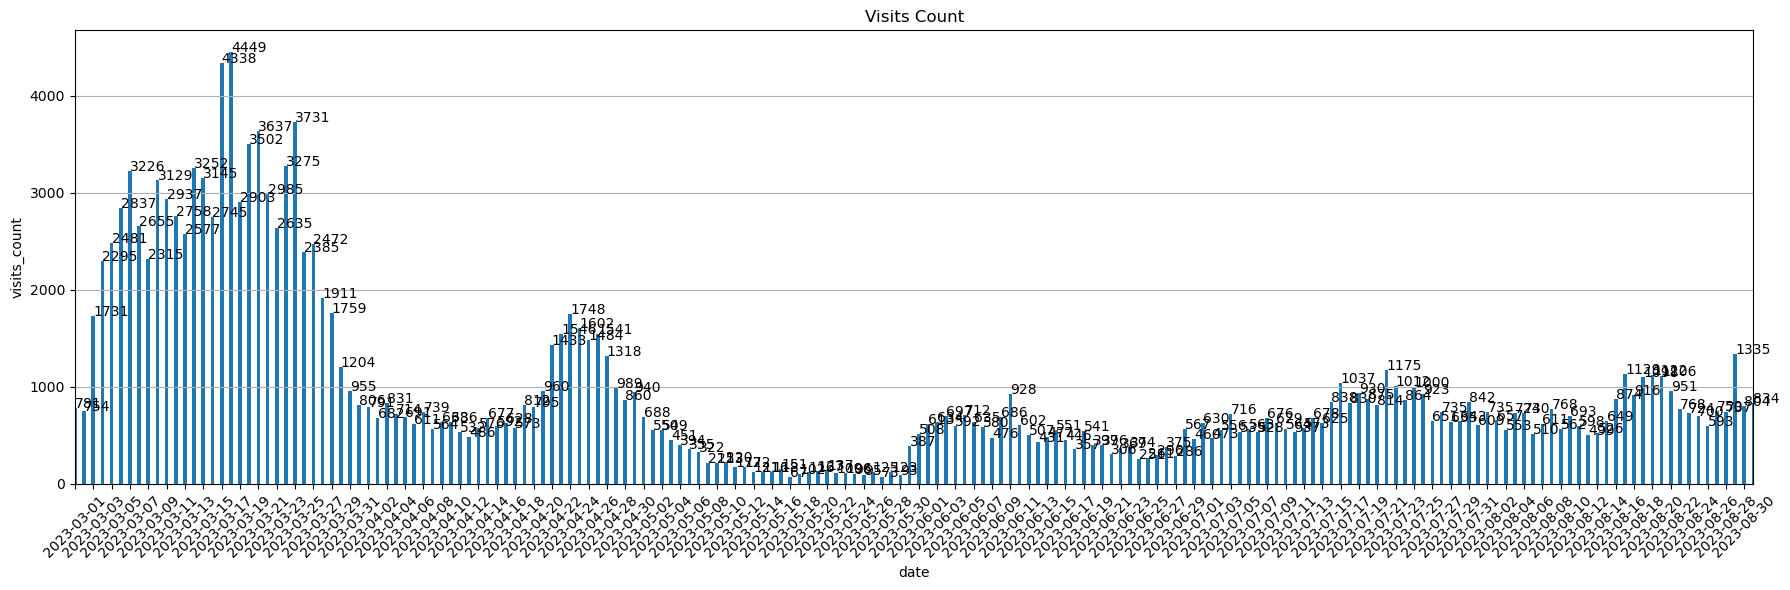

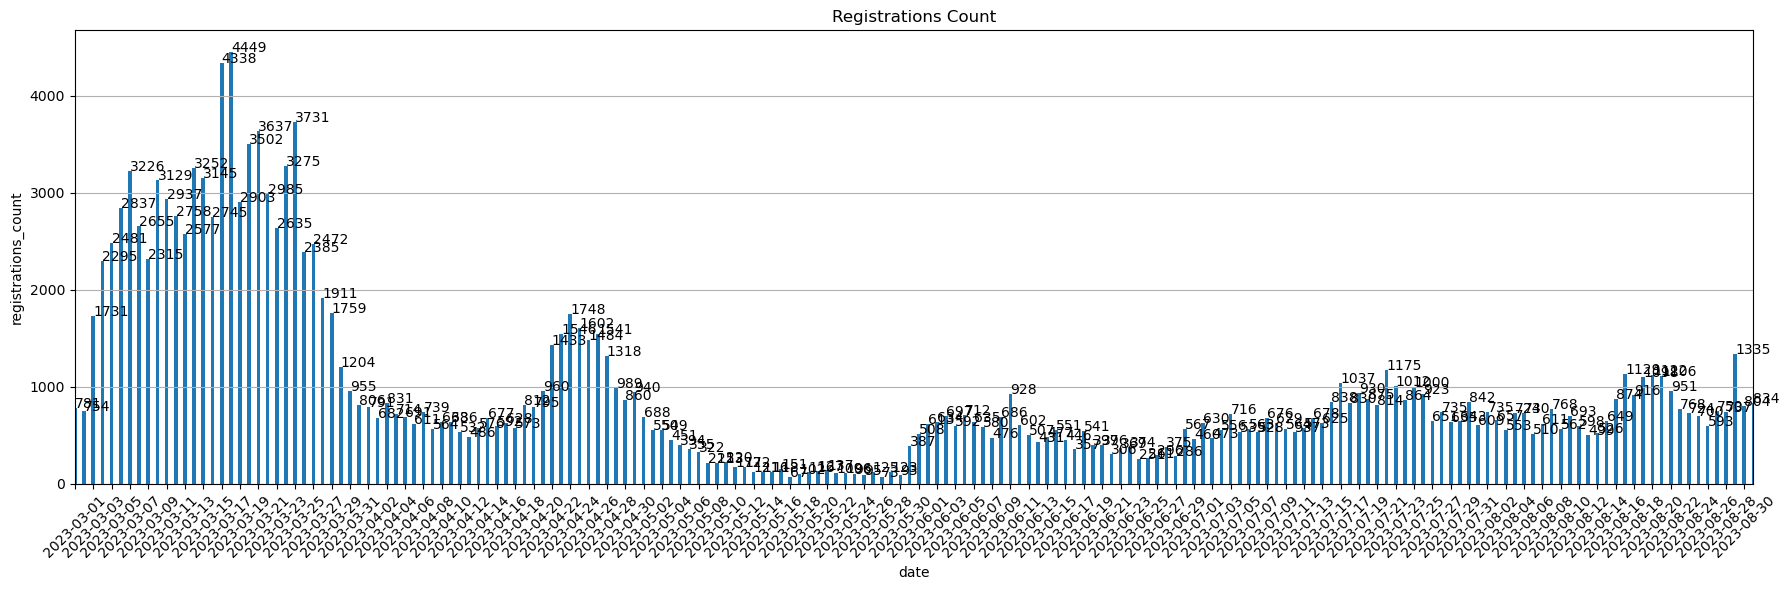

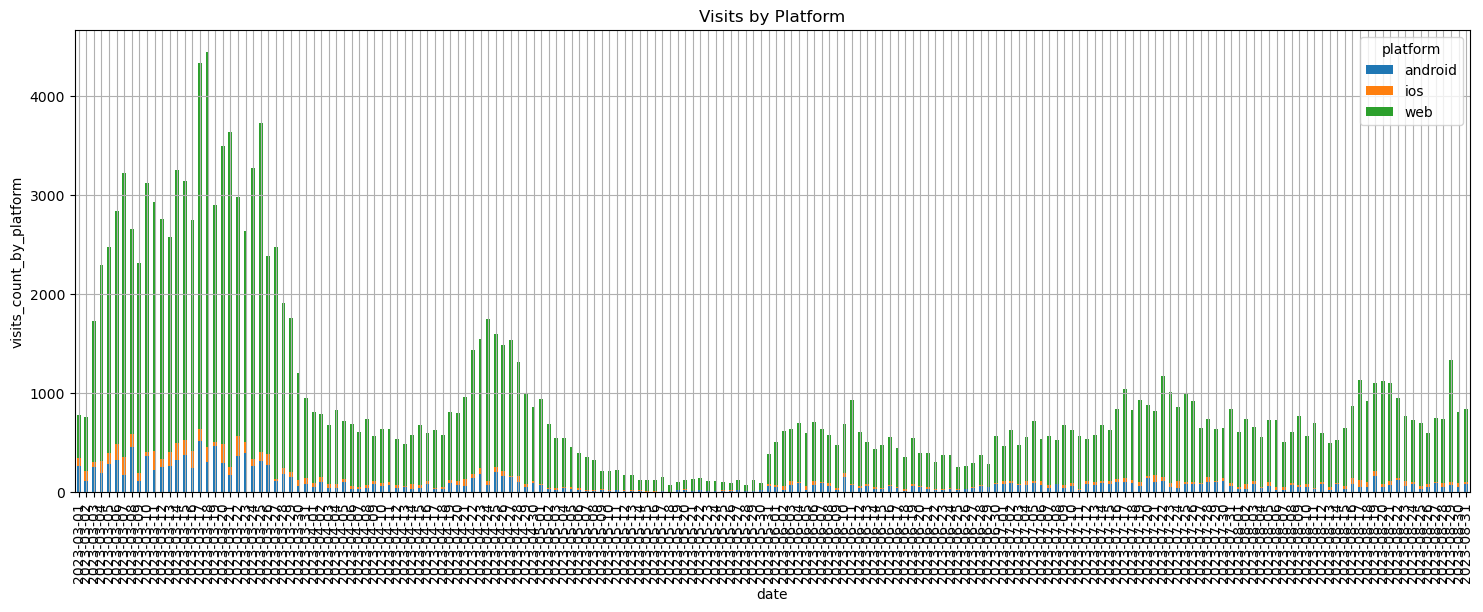

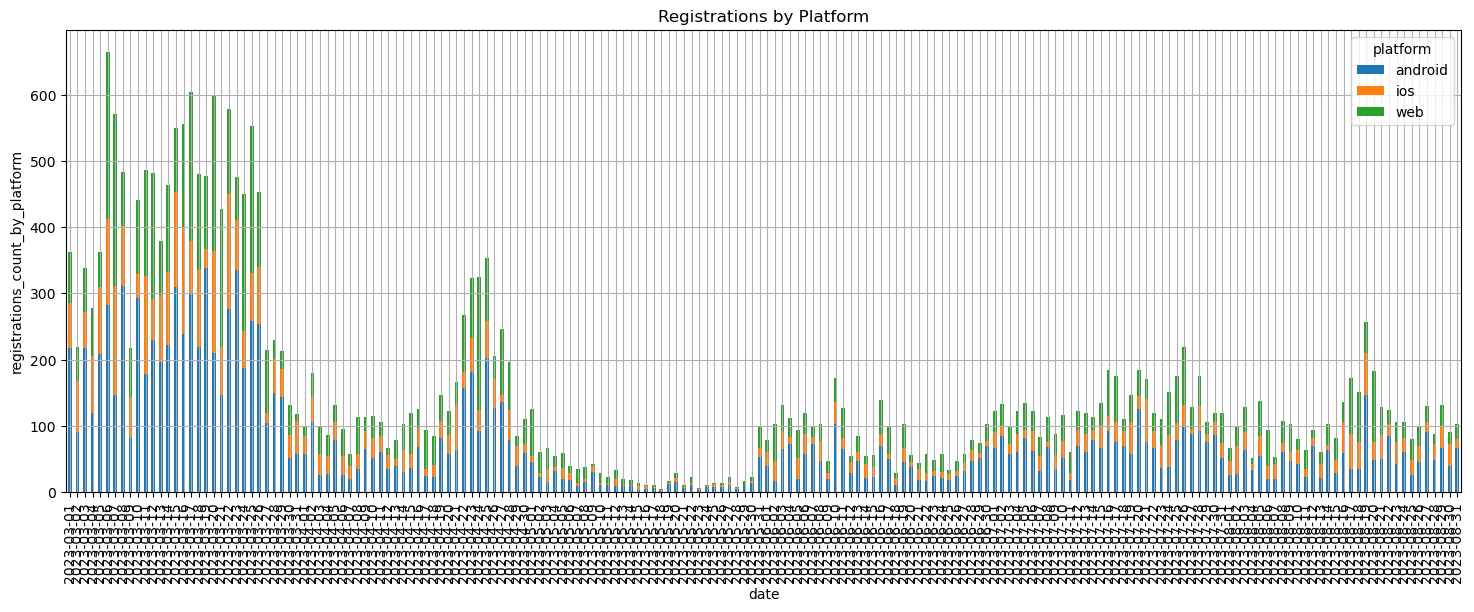

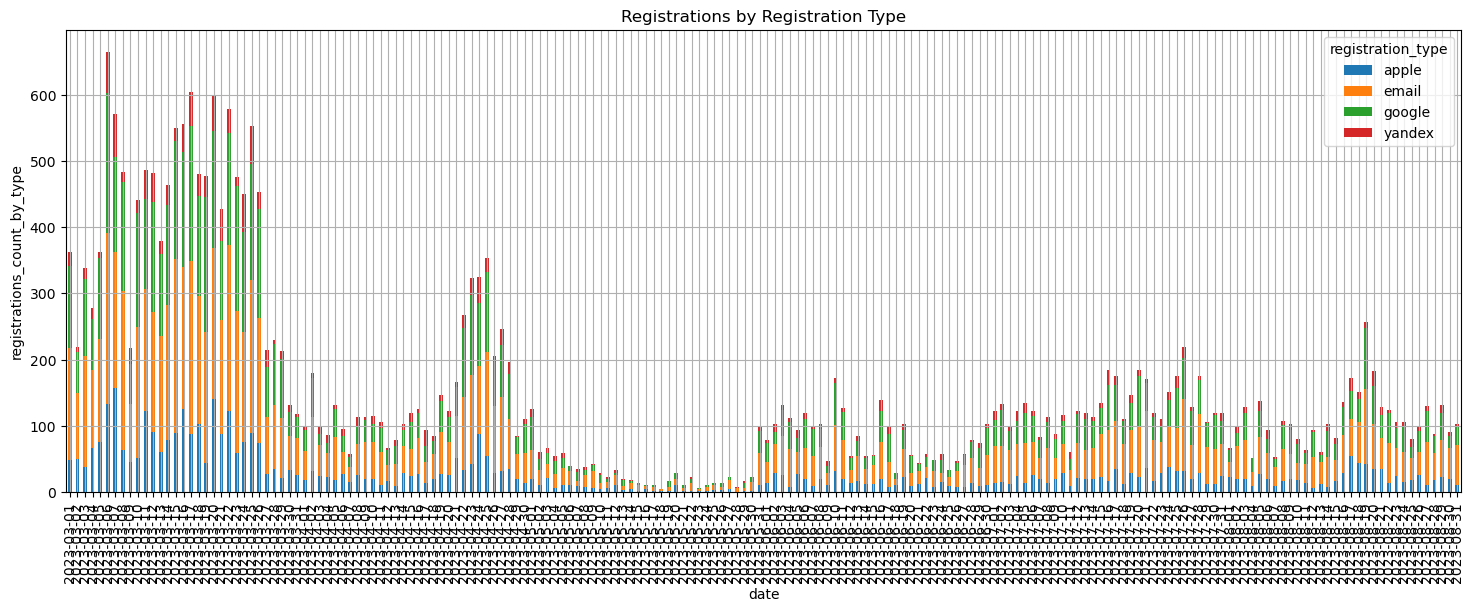

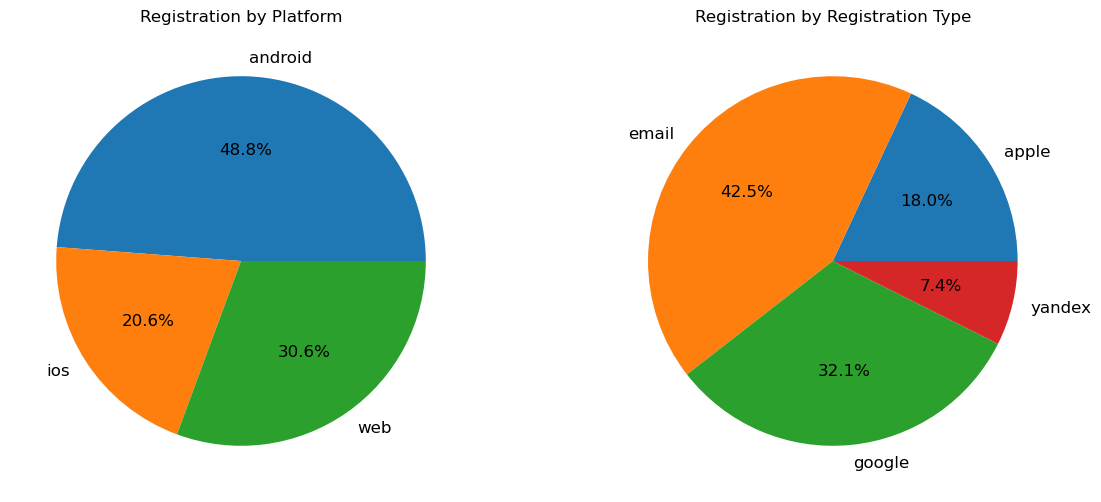

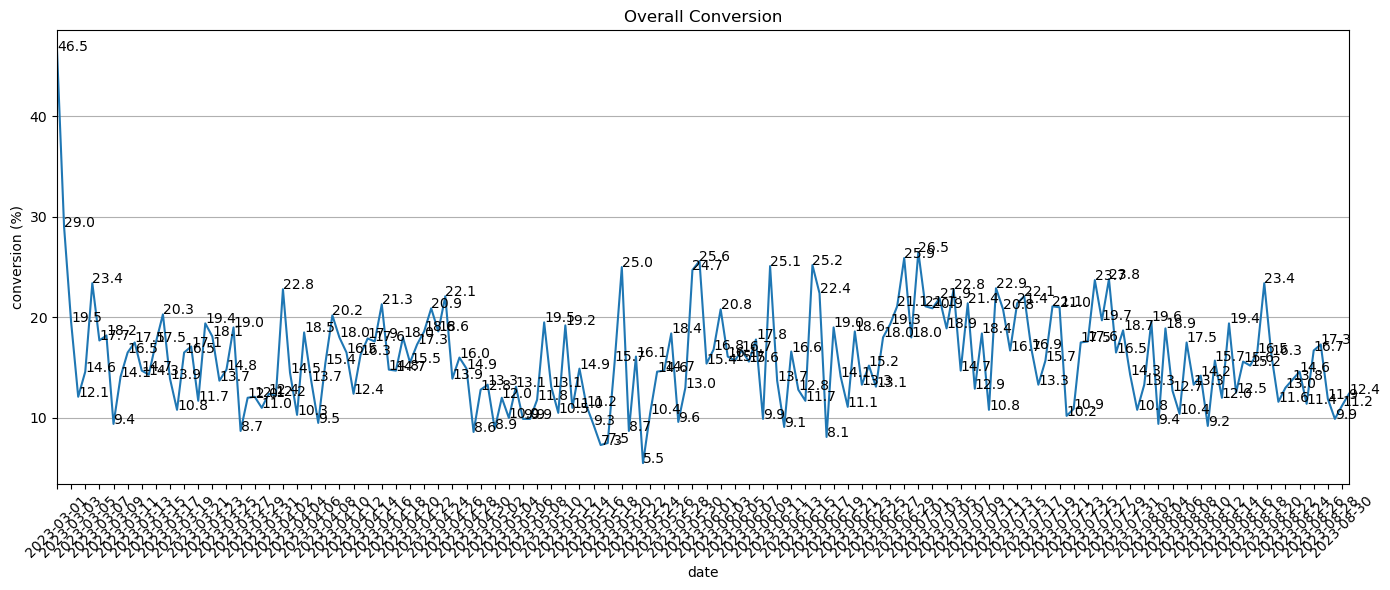

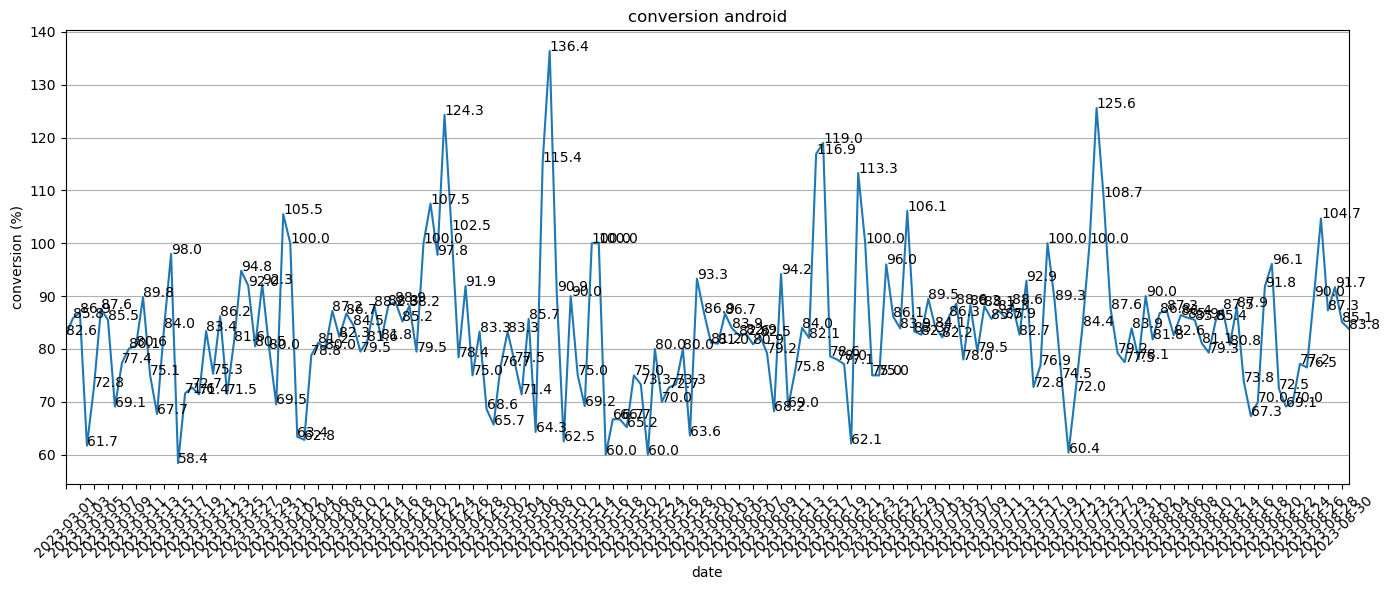

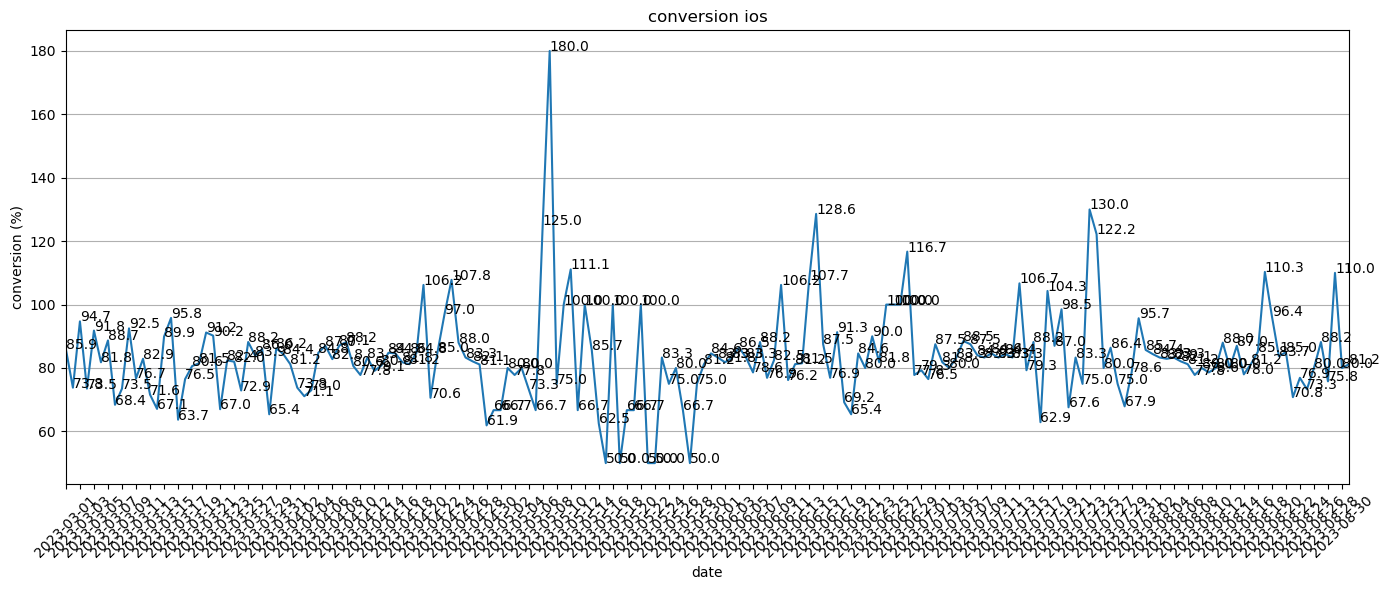

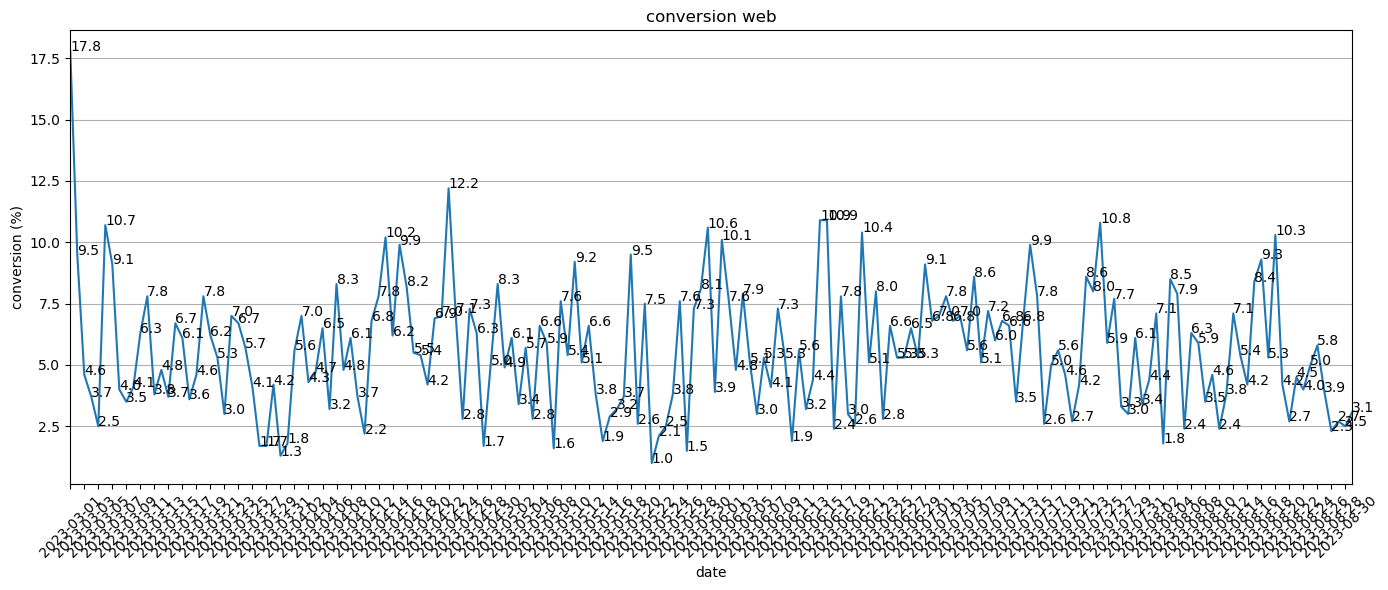

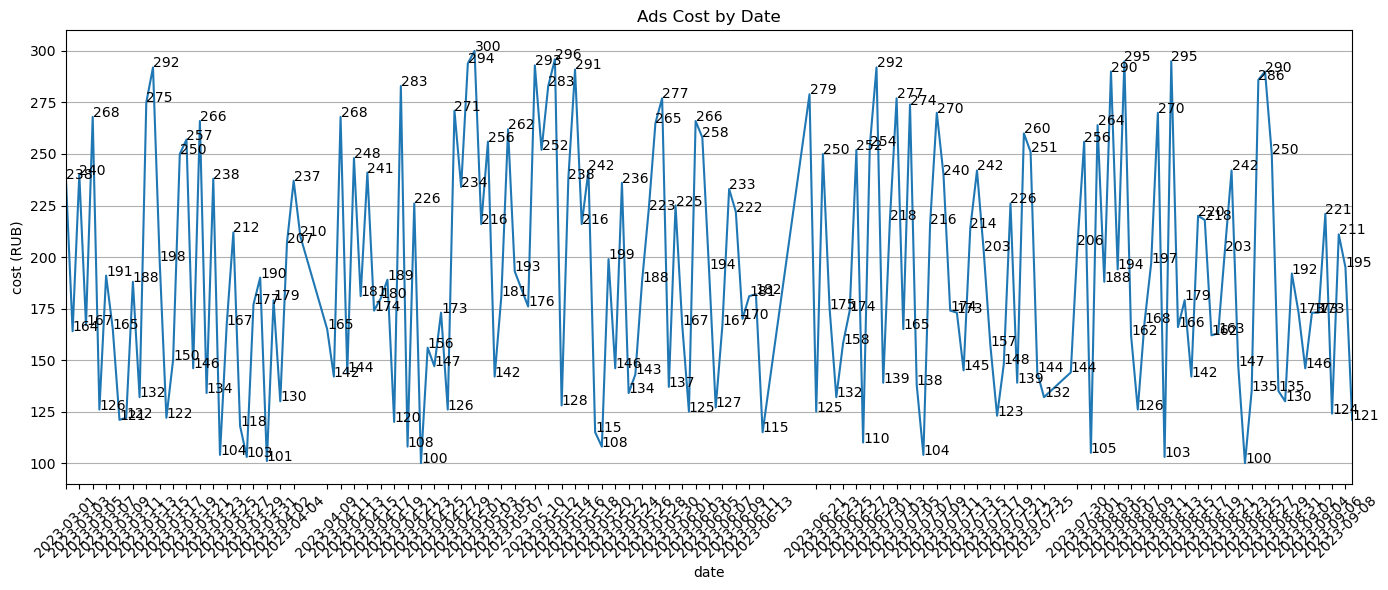

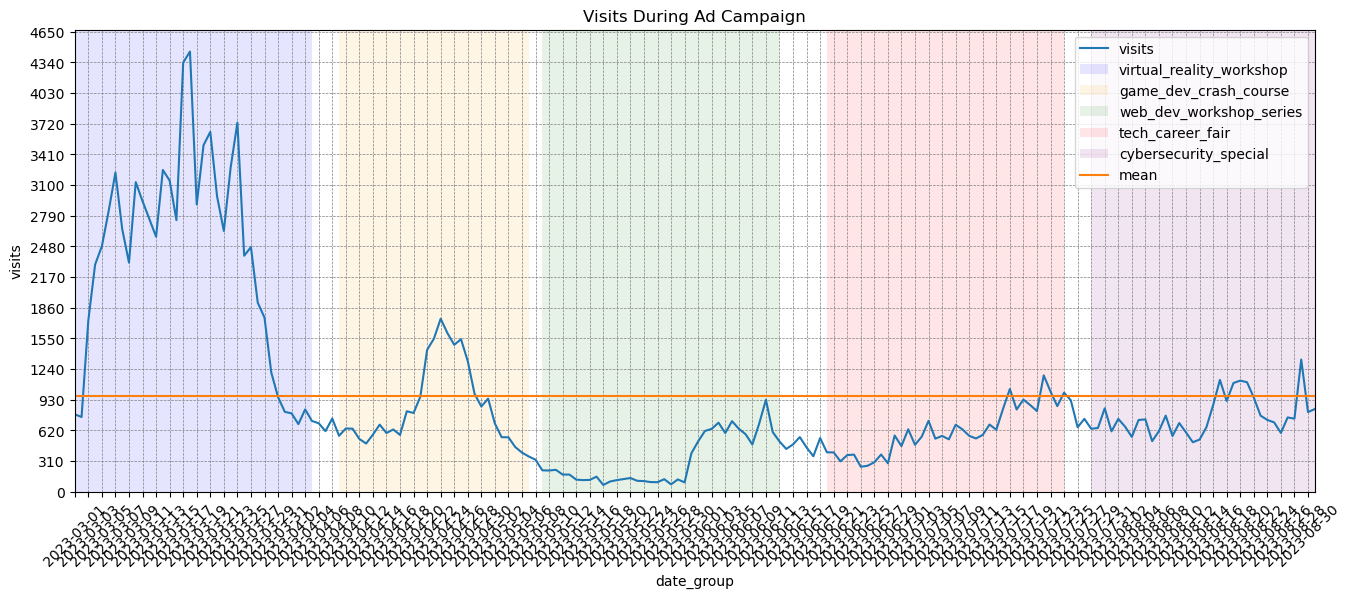

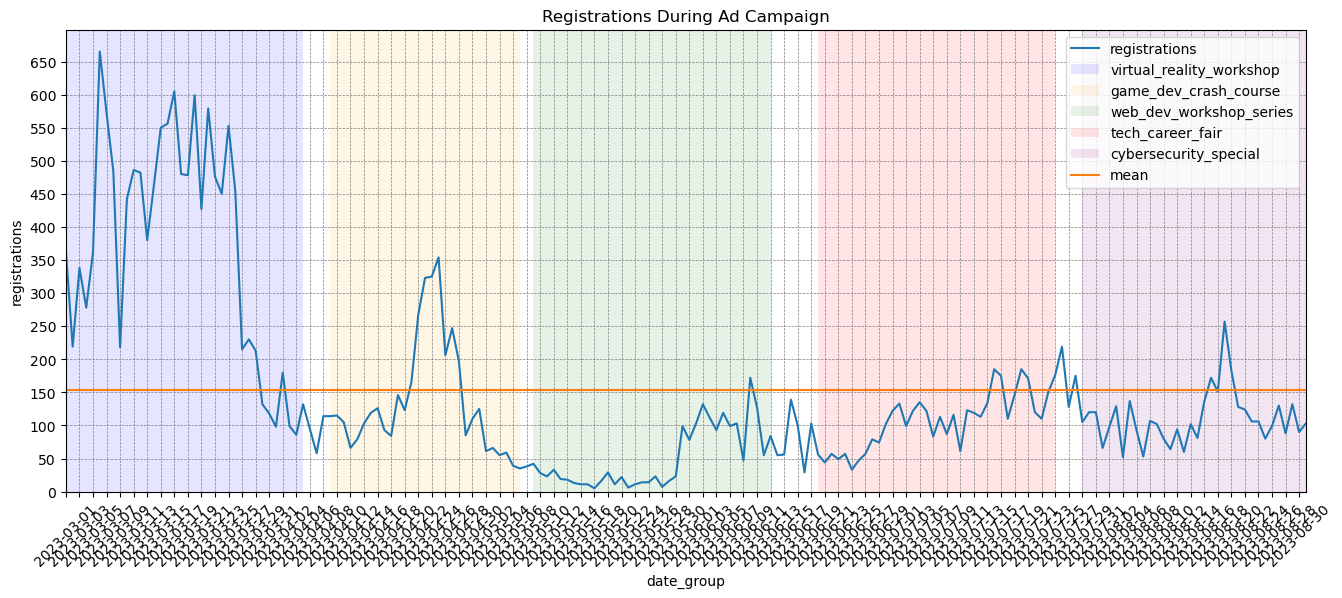

In [11]:
run_all()